# Correlations
This notebook displays the correlation between viral barcode expression in the transcriptome, supernatant, and second infection.

## Notebook setup
Import python modules:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import pandas as pd

import plotnine as p9

import scipy

import statsmodels.stats.multitest

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
# Hardcoded for now
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial2_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_by_cell_filtered_csv = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_filtered.csv.gz'
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial2_viral_bc_in_progeny_freq.csv.gz'
expt = 'scProgenyProduction_trial2'
plot = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_correlations.pdf'
barcoded_viral_genes = ['fluHA', 'fluNA']

## Organize data
Read the cell barcodes and tags into a pandas dataframe. Only keep relevant columns.

In [3]:
all_cells = pd.read_csv(viral_tag_by_cell_csv)
all_cells = all_cells[['cell_barcode',
                       'infected',
                       'infecting_viral_tag']]
display(all_cells)

,cell_barcode,infected,infecting_viral_tag
0,AAACCCAAGTAGGTTA,True,syn
1,AAACCCACAAGGCCTC,True,syn
2,AAACCCACACACACGC,True,both
3,AAACCCATCGTGCATA,True,syn
4,AAACCCATCTACTGCC,False,none
...,...,...,...
7436,TTTGGTTGTTAAGCAA,False,none
7437,TTTGGTTTCGTCGCTT,False,none
7438,TTTGTTGCATGTGGTT,True,wt
7439,TTTGTTGTCGTCGGGT,False,none


Read the viral barcode frequencies from the transcriptome. Filter out viral barcodes that didn't pass significant threshold.

In [4]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_by_cell_filtered_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
transcriptome_viral_bc_freqs = (transcriptome_viral_bc_freqs
                                .query('reject_uninfected == True'))
transcriptome_viral_bc_freqs = transcriptome_viral_bc_freqs.drop(columns = 'reject_uninfected')
display(transcriptome_viral_bc_freqs)

,cell_barcode,gene,viral_barcode,frac_viral_bc_UMIs
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,0.002609
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,0.002236
6,AAACCCAAGTAGGTTA,fluHA,CTTAACTGTATATTCG,0.004844
8,AAACCCAAGTAGGTTA,fluHA,TCTTAAGTATATCAGA,0.002422
12,AAACCCAAGTAGGTTA,fluHA,TGTAAATAGAGTTCGC,0.003726
...,...,...,...,...
58905,TTTGGTTCATCTGCGG,fluNA,TTGTATAAAAATACAG,0.007323
58906,TTTGGTTGTCGGTGTC,fluNA,AATAAGCGGCTCTTTG,0.003318
58913,TTTGTTGCATGTGGTT,fluNA,CACCCCGTTAGTGGGG,0.007294
58923,TTTGTTGTCTAGGAAA,fluNA,GAACCCGATGGGGAAT,0.009800


Read the viral barcode frequencies from the progeny. **For now just work with supernatant data. Remove second_infection frequencies.**

In [5]:
progeny_viral_bc_freqs = pd.read_csv(viral_bc_in_progeny_freq_csv)
assert set(progeny_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .rename(columns={'barcode': 'viral_barcode',
                                           'tag': 'infecting_viral_tag',
                                           'mean_freq': 'freq_progeny'}))
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .query('source == "second_infection"'))
progeny_viral_bc_freqs = progeny_viral_bc_freqs.drop(columns = 'source')
display(progeny_viral_bc_freqs)

,infecting_viral_tag,gene,viral_barcode,freq_progeny
0,syn,fluHA,AAAAAAAGTAAATCTT,5.255458e-05
1,syn,fluHA,AAAAAAATCTTAATAA,2.031765e-06
2,syn,fluHA,AAAAAAATCTTAATGA,8.673284e-05
3,syn,fluHA,AAAAAACCCAATTATT,1.061100e-06
4,syn,fluHA,AAAAAACCCGATTATT,3.408782e-05
...,...,...,...,...
90711,wt,fluNA,TTTTTGTTCCTTTGTT,4.064305e-06
90712,wt,fluNA,TTTTTTAGAAAACGTC,7.421144e-06
90713,wt,fluNA,TTTTTTCGGCGAGTGC,7.827482e-07
90714,wt,fluNA,TTTTTTCGGCGAGTGT,7.827482e-07


Merge dataframes to one. This will be done in two steps. First, merge transcriptome frequencies with all cells tag info.  Then, merge supernatant frequencies into this dataframe.

Structure of the final dataframe should be as follows:
1. Cell barcode
2. Infected
3. Infecting viral tag
4. Gene.
5. Viral barcode
6. Frequency in transcriptome (`frac_viral_bc_UMIs`)
7. Frequency in supernatant sequencing (`freq_progeny`)

In [6]:
viral_bc_freqs = pd.merge(
    left=pd.concat([all_cells.assign(gene=gene)
                    for gene in barcoded_viral_genes]),
    right=transcriptome_viral_bc_freqs,
    how='outer',
    on=['cell_barcode', 'gene'],
    validate='one_to_many')
assert (viral_bc_freqs['cell_barcode'].unique() ==
        all_cells['cell_barcode'].unique()).all(), \
       "Cell barcodes in merged dataframe don't " \
       "match barcodes in source data."
assert (viral_bc_freqs['viral_barcode'].nunique() ==
        transcriptome_viral_bc_freqs['viral_barcode'].nunique()), \
       "Number of viral barcodes in merged dataframe don't " \
       "match number of barcodes in source data."

viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=progeny_viral_bc_freqs,
    how='outer',
    on=['viral_barcode', 'gene', 'infecting_viral_tag'])
# Need to think of what asserts to include here

display(viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,freq_progeny
0,AAACCCAAGTAGGTTA,True,syn,fluHA,AGAATCGACACATGTC,0.002609,6.210448e-05
1,GTAGGTTTCGTTTACT,True,syn,fluHA,AGAATCGACACATGTC,0.002756,6.210448e-05
2,AAACCCAAGTAGGTTA,True,syn,fluHA,CACGGATGGTGTACGA,0.002236,5.088456e-05
3,AAACCCAAGTAGGTTA,True,syn,fluHA,CTTAACTGTATATTCG,0.004844,4.979391e-04
4,AAAGTCCAGGATTTAG,True,syn,fluHA,CTTAACTGTATATTCG,0.003273,4.979391e-04
...,...,...,...,...,...,...,...
104816,NaN,NaN,wt,fluNA,TTTTTGTTCCTTTGTT,NaN,4.064305e-06
104817,NaN,NaN,wt,fluNA,TTTTTTAGAAAACGTC,NaN,7.421144e-06
104818,NaN,NaN,wt,fluNA,TTTTTTCGGCGAGTGC,NaN,7.827482e-07
104819,NaN,NaN,wt,fluNA,TTTTTTCGGCGAGTGT,NaN,7.827482e-07


Check whether each viral barcode is found in both supernatant and transcriptome data:

In [7]:
# Code TBD

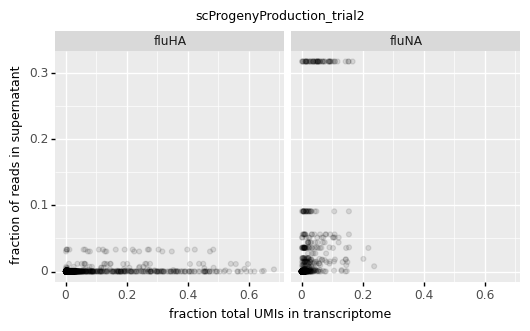

<ggplot: (8785886914777)>

In [8]:
fig = (p9.ggplot(viral_bc_freqs.dropna(),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='fraction total UMIs in transcriptome',
               y='fraction of reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)